# TF-IDF + persistence homology

## TF-IDF

In [1]:
import numpy as np
from scipy.sparse import csr_matrix, linalg, csgraph
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re
import tools

## TODO

- Un bon preprocessing
- Exploiter des propriétés sur les barcodes

### Notes on the implementation

- On n'utilise pas ```for``` dès possible
- On utilise sparse matrices

In [2]:
def my_split(docs : list[str]) -> list[list[str]]:
  return [[w.lower() for w in re.sub(r'[^\w]', ' ', s).split() if w.isalpha() and len(w) >= 3] for s in docs]

def tfidf(docs : list[list[str]]) -> tuple[list[str], np.ndarray, list[np.ndarray]]:
    words = []
    for doc in docs:
        words.extend(doc)
    words = np.unique(words)
    lk = dict(zip(words, range(len(words))))
    tf = np.zeros((len(docs), len(words)), dtype=np.float64)
    for i, doc in enumerate(docs):
        indices, counts = np.unique([lk[term] for term in doc], return_index=True)
        tf[i, indices] = counts/len(doc)

    df = np.zeros((len(words),), dtype=np.float64)
    for doc in docs:
        df[np.unique([lk[term] for term in doc])] += 1
    idf = np.log(len(docs) / df)

    tfidf = tf * idf
    return words, idf, tfidf

In [3]:
pairs = tools.categories_description_pairs("details.json")[:2000]

In [4]:
categories = list(set(((sum([p[0].split('|') for p in pairs],[])))))
categories.remove('')
print(len(categories), categories)

175 ['Far-west', 'Jeu sans investissement', 'Jeux de lettres', 'Toucher', 'Desert', 'Question', 'Jeux de plateau', 'Colonisation', 'Chat', 'Livre dont vous êtes le héros', 'Plateau modulaire', 'Chant & Danse', 'Astronomie et Espace', 'Abstrait', 'Echange - troc', 'Cartes à jouer', 'Enigme', 'Observation', 'Politique', 'Mémoire', 'Animaux', 'Connaissances', 'Connexions', 'Équilibre', 'Art', 'Diplomatie', 'équipe', 'Vampire', 'Hospitalier', 'Jeu en ligne', "Points d'action", 'Fruits & légumes', 'Antiquité', 'Bande dessinée', 'Amateur', 'Dessin', "Placement d'ouvrier", 'Parcours', 'Tuile', 'Vote', 'Labyrinthe', 'Jeux de figurines', 'Pirate', 'Exploration', 'Jeux de cartes', 'Mime', 'Prospection minière', 'Locomotion & voyage', 'Rapidité', 'Contes, Mythes & Légendes', 'Renaissance', 'Rôle', 'Préhistorique', 'Gestion de main', 'Taquin', 'Aventures dans la jungle', 'Placement', 'Ambiance', 'Empilement', 'Levées', 'Bourse & finances', 'Majorité', 'Cambriolage', 'Jeu de logique', 'Affrontement

In [5]:
docs = [p[1] for p in pairs]
docs = my_split(docs)
for x in docs[:10]:
    print(x)

['marvel', 'united', 'unis', 'contre', 'les', 'super', 'vilains', 'red', 'skull', 'ultron', 'taskmaster', 'attaquent', 'ville', 'chacun', 'avec', 'son', 'propre', 'plan', 'diabolique', 'destruction', 'domination', 'pour', 'les', 'arrêter', 'des', 'super', 'héros', 'comme', 'captain', 'america', 'iron', 'man', 'captain', 'marvel', 'unissent', 'leurs', 'forces', 'final', 'les', 'efforts', 'combinés', 'ces', 'héros', 'suffiront', 'ils', 'sauver', 'monde', 'dans', 'marvel', 'united', 'les', 'joueurs', 'doivent', 'travailler', 'ensemble', 'pour', 'arrêter', 'les', 'plans', 'supervillain', 'malfaisant', 'ils', 'utiliseront', 'paquet', 'personnalisé', 'pouvoirs', 'capacités', 'chaque', 'héros', 'jouant', 'sur', 'les', 'forces', 'des', 'uns', 'des', 'autres', 'pour', 'plus', 'effet', 'tout', 'essayant', 'terminer', 'les', 'missions', 'éliminer', 'méchant', 'avant', 'soit', 'trop', 'tard', 'ils', 'battront', 'dans', 'des', 'endroits', 'tout', 'autour', 'ville', 'final', 'soit', 'ville', 'sera',

In [6]:
words, idf, vecs = tfidf(docs)
vecs = csr_matrix(vecs)

In [7]:
print("Number of words", len(words))
print(words)

Number of words 21583
['aaaaahhhh' 'aaron' 'abaddon' ... 'œuvré' 'ลอยกระทง' 'エセ芸術家ニューヨークへ行く']


- Il y a trop de mots, parce que je n'ai pas utilisé stemmer.

In [8]:
print("IDF: ", list(reversed(sorted(list(zip(words, idf)))))[:20])
print("IDF: ", (sorted(list(zip(idf, words))))[:20])

IDF:  [('エセ芸術家ニューヨークへ行く', 7.600902459542082), ('ลอยกระทง', 7.600902459542082), ('œuvré', 7.600902459542082), ('œuvres', 5.991464547107982), ('œuvreront', 7.600902459542082), ('œuvrer', 6.502290170873972), ('œuvrent', 6.214608098422191), ('œuvre', 5.2030071867437115), ('œufs', 6.502290170873972), ('œuf', 6.907755278982137), ('œillets', 6.907755278982137), ('œil', 5.403677882205863), ('ïle', 7.600902459542082), ('îlots', 7.600902459542082), ('îlot', 7.600902459542082), ('îles', 4.4654082436129325), ('île', 3.557851191707532), ('êtres', 6.502290170873972), ('être', 1.5702171992808192), ('êtes', 2.4135166537013273)]
IDF:  [(0.2516716349287479, 'les'), (0.3467246130855643, 'des'), (0.3652833184753325, 'pour'), (0.5310283310835101, 'une'), (0.5395680926316446, 'dans'), (0.5586162876023393, 'est'), (0.5709295478356962, 'jeu'), (0.605136303237232, 'vous'), (0.6871651088823978, 'qui'), (0.7225759912507576, 'plus'), (0.8675005677047231, 'que'), (0.9519179095173061, 'sur'), (0.99695863494161, 'av

## Persistence homology dim 0

On the function
$$
f(p) = \min_{q \in A}(p-q)
$$

In [9]:
def compute_barcode(X : csr_matrix) -> np.ndarray:
    n = X.shape[0]
    distances = metrics.pairwise_distances(X, metric='euclidean', n_jobs=-1)
    deathes = [np.min([distances[i, j] for j in range(i+1, n)], initial=np.inf) for i in range(n)]
    return deathes

In [10]:
deathes = compute_barcode(vecs)
print(deathes)
print(np.unique(deathes))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

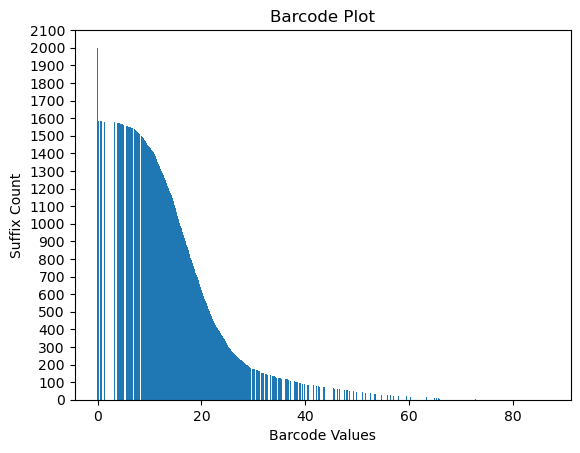

In [11]:
def graph():
    x, y = np.unique(deathes, return_counts=True)
    # fix np.inf
    x[-1] = x[-2]

    y = y[::-1].cumsum()[::-1]
    fig, ax = plt.subplots()
    ax.bar(x, y, width=0.1)
    tick_spacing = 100
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xlabel('Barcode Values')
    ax.set_ylabel('Suffix Count')
    ax.set_title('Barcode Plot')
    plt.show()
graph()

- Il existe un virage et des espaces à partir de 200, et on a bien environ 200 catégories. Peut-être on peut trouver quelque chose.